In [6]:
import warnings

warnings.filterwarnings('ignore')

In [8]:
import pandas as pd

cnts = pd.read_csv("../data/binfo1-datapack1/read_counts.txt", sep='\t', comment='#', index_col=0)

print(cnts.head())

                                                     Chr  \
Geneid                                                     
ENSMUSG00000102693.2                                chr1   
ENSMUSG00000064842.3                                chr1   
ENSMUSG00000051951.6  chr1;chr1;chr1;chr1;chr1;chr1;chr1   
ENSMUSG00000102851.2                                chr1   
ENSMUSG00000103377.2                                chr1   

                                                                  Start  \
Geneid                                                                    
ENSMUSG00000102693.2                                            3143476   
ENSMUSG00000064842.3                                            3172239   
ENSMUSG00000051951.6  3276124;3276746;3283662;3283832;3284705;349192...   
ENSMUSG00000102851.2                                            3322980   
ENSMUSG00000103377.2                                            3435954   

                                                     

In [9]:
cnts['clip_enrichment'] = cnts['CLIP-35L33G.bam'] / cnts['RNA-control.bam']
cnts['rden_change'] = (cnts['RPF-siLin28a.bam'] / cnts['RNA-siLin28a.bam']) / (cnts['RPF-siLuc.bam'] / cnts['RNA-siLuc.bam'])

print(cnts.head())

                                                     Chr  \
Geneid                                                     
ENSMUSG00000102693.2                                chr1   
ENSMUSG00000064842.3                                chr1   
ENSMUSG00000051951.6  chr1;chr1;chr1;chr1;chr1;chr1;chr1   
ENSMUSG00000102851.2                                chr1   
ENSMUSG00000103377.2                                chr1   

                                                                  Start  \
Geneid                                                                    
ENSMUSG00000102693.2                                            3143476   
ENSMUSG00000064842.3                                            3172239   
ENSMUSG00000051951.6  3276124;3276746;3283662;3283832;3284705;349192...   
ENSMUSG00000102851.2                                            3322980   
ENSMUSG00000103377.2                                            3435954   

                                                     

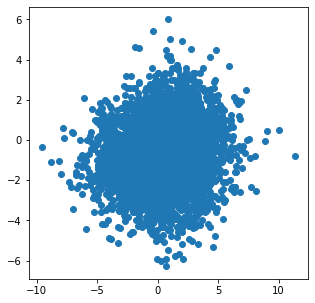

In [10]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(
    np.log2(cnts['clip_enrichment']),
    np.log2(cnts['rden_change'])
)

In [11]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

mouselocal = pd.read_csv('https://hyeshik.qbio.io/binfo/mouselocalization-20210507.txt', sep='\t')

print(mouselocal.head())

              gene_id            Gene names       type
0  ENSMUSG00000000001                 Gnai3  cytoplasm
1  ENSMUSG00000000028  Cdc45 Cdc45l Cdc45l2    nucleus
2  ENSMUSG00000000049            Apoh B2gp1  cytoplasm
3  ENSMUSG00000000058                  Cav2  cytoplasm
4  ENSMUSG00000000085                 Scmh1    nucleus


In [12]:
mouselocal = mouselocal.set_index('gene_id')

print(mouselocal.head())

                              Gene names       type
gene_id                                            
ENSMUSG00000000001                 Gnai3  cytoplasm
ENSMUSG00000000028  Cdc45 Cdc45l Cdc45l2    nucleus
ENSMUSG00000000049            Apoh B2gp1  cytoplasm
ENSMUSG00000000058                  Cav2  cytoplasm
ENSMUSG00000000085                 Scmh1    nucleus


In [13]:
fig_target = cnts[['clip_enrichment', 'rden_change']]

# remove gene id version
fig_target.index = [x[:x.rfind('.')] for x in list(fig_target.index)]

# remove inf, -inf, NaN
fig_target = fig_target.replace([np.inf, -np.inf], np.nan)
fig_target_= fig_target.dropna(axis=0)

# remove unmatched (which shows up as NaN)
fig_target_ = pd.merge(mouselocal, fig_target_, left_index=True, right_index=True, how='right')
fig_target_ = fig_target_.dropna(axis=0)

print(fig_target_.head())

                              Gene names       type  clip_enrichment  \
ENSMUSG00000000001                 Gnai3  cytoplasm         2.762901   
ENSMUSG00000000028  Cdc45 Cdc45l Cdc45l2    nucleus         1.011928   
ENSMUSG00000000058                  Cav2  cytoplasm         0.000000   
ENSMUSG00000000085                 Scmh1    nucleus         1.051546   
ENSMUSG00000000093                  Tbx2    nucleus         0.000000   

                    rden_change  
ENSMUSG00000000001     0.637359  
ENSMUSG00000000028     0.521917  
ENSMUSG00000000058     0.000000  
ENSMUSG00000000085     0.277646  
ENSMUSG00000000093     0.200000  


In [14]:
def sampling(size, seed):
    cytoplasm = fig_target_.loc[fig_target_.type == 'cytoplasm']
    cytoplasm_sample = cytoplasm.sample(n = size, random_state=seed)

    nucleus = fig_target_.loc[fig_target_.type == 'nucleus']
    nucleus_sample = nucleus.sample(n = size, random_state=seed)

    memprotein = fig_target_.loc[fig_target_.type == 'integral membrane']
    memprotein_sample = memprotein.sample(n = size, random_state=seed)

    fig_target_df = pd.concat([
        cytoplasm_sample, nucleus_sample, memprotein_sample
    ])

    return fig_target_df

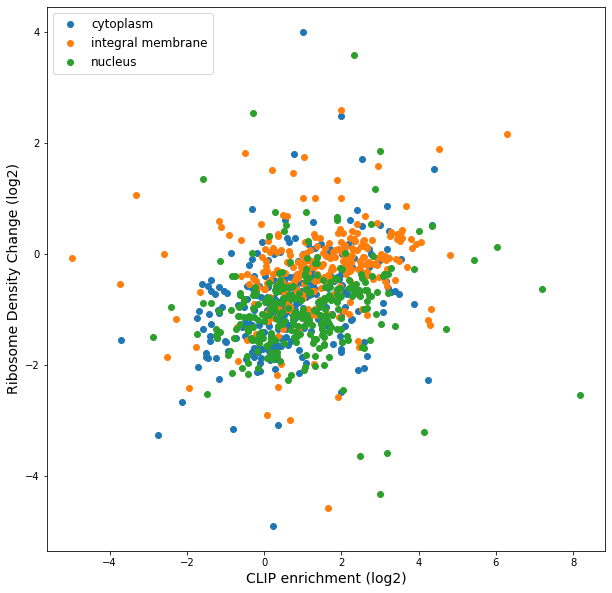

In [15]:
fig_target_df = sampling(size=300, seed=125)

fig_groups = fig_target_df.groupby('type')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for name, group in fig_groups:
    ax.plot(
    np.log2(group.clip_enrichment), 
    np.log2(group.rden_change),
    marker = 'o',
    linestyle = '',
    label = name
)

ax.legend(fontsize=12, loc='upper left')
plt.xlabel("CLIP enrichment (log2)", fontsize=14)
plt.ylabel("Ribosome Density Change (log2)", fontsize=14)
plt.show()